# Data Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn import preprocessing

In [2]:
data = pd.read_csv('data/train.csv')
data['Date'] = pd.to_datetime(data['Date'])
data.index = data['Date']

In [3]:
data.head()

,ID,Province_State,Date,Confirmed,Deaths,Recovered,Active,Incident_Rate,People_Tested,People_Hospitalized,Mortality_Rate,Testing_Rate,Hospitalization_Rate
Date,,,,,,,,,,,,,
2020-04-12,0,Alabama,2020-04-12,3563,93,NaN,3470.0,75.988020,21583.0,437.0,2.610160,460.300152,12.264945
2020-04-12,1,Alaska,2020-04-12,272,8,66.0,264.0,45.504049,8038.0,31.0,2.941176,1344.711576,11.397059
2020-04-12,2,Arizona,2020-04-12,3542,115,NaN,3427.0,48.662422,42109.0,NaN,3.246753,578.522286,NaN
2020-04-12,3,Arkansas,2020-04-12,1280,27,367.0,1253.0,49.439423,19722.0,130.0,2.109375,761.753354,10.156250
2020-04-12,4,California,2020-04-12,22795,640,NaN,22155.0,58.137726,190328.0,5234.0,2.812020,485.423869,22.961176


# Data Interpolation

In [4]:
data.isna().sum()

ID                         0
Province_State             0
Date                       0
Confirmed                  0
Deaths                     0
Recovered               1329
Active                     0
Incident_Rate              0
People_Tested              0
People_Hospitalized     2053
Mortality_Rate             0
Testing_Rate               0
Hospitalization_Rate    2053
dtype: int64

Some columns are missing values. Let's see if we can interpolate. 

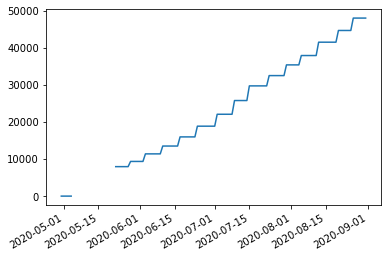

In [5]:
alabama = data.loc[data['Province_State'] == 'Alabama'].copy()

fig, ax = plt.subplots()
fig.autofmt_xdate()
ax.plot(alabama['Recovered'])

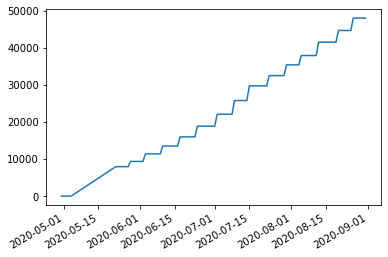

In [6]:
alabama['Recovered'] = alabama['Recovered'].interpolate(method='time')

fig, ax = plt.subplots()
fig.autofmt_xdate()
ax.plot(alabama['Recovered'])

Well, that was easy. 
Can we apply it to our entire dataset on a state-to-state basis? 

In [7]:
interpolated = pd.DataFrame(columns=data.columns)
states = data.groupby('Province_State')
for state_name, state_data in states: 
    interpolated = interpolated.append(state_data.interpolate(method='time'))

In [8]:
interpolated.isna().sum()

ID                        0
Province_State            0
Date                      0
Confirmed                 0
Deaths                    0
Recovered               396
Active                    0
Incident_Rate             0
People_Tested             0
People_Hospitalized      66
Mortality_Rate            0
Testing_Rate              0
Hospitalization_Rate     66
dtype: int64

As seen above, interpolation doesn't catch *every* `NaN` value. 
Values at the beginning of our timeframe are not processed due to lack of a "starting point" to interpolate from. 
Seeing as we're analyzing our data on a column-by-column basis, I don't think this will be an issue; our models can just treat the data as "starting" from a later date. 

**When processing this data, I'd recommend dropping every row with a `NaN` value.**

In [9]:
# Sort the data back into the original order, then write to disk. 
disk = interpolated.copy()
disk.index = interpolated['ID']
disk.sort_index(inplace=True)
disk.to_csv('train-interpolated.csv', index=False)
del disk

# Normalization

Justin has normalized and scaled the data. Let's modify his code a bit, then apply it to our already-interpolated dataset.

In [10]:
scaled = pd.DataFrame()

# Group data by State for cleaning.
for name, group in interpolated.groupby('Province_State'):
    # Scale all numerical categories
    for cat in list(interpolated.columns)[3:]:
        # Standard Scale numeric columns (State-wise)
        mean = group[cat].mean()
        var = group[cat].var()
        group[cat] = group[cat].apply(lambda x : (x - mean)/var)
    scaled = pd.concat([scaled, group], ignore_index=True)

# Standard Scale all numeric columns (GLOBALLY)
scaler = preprocessing.StandardScaler()
c = scaled.select_dtypes('number').columns[1:]
scaled[c] = scaler.fit_transform(scaled[c])

In [11]:
# Sort the data back into the original order, then write to disk. 
disk = scaled.copy()
disk.index = scaled['ID']
disk.sort_index(inplace=True)
disk.to_csv('train-scaled.csv', index=False)
del disk

How do we unscale the data points? 

In [ ]:
scaler.inverse_transformation()
# NOTE: This might not work. Justin already scales, *then* runs the scaler? WTF?